<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Импорт-данных" data-toc-modified-id="Импорт-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт данных</a></span></li><li><span><a href="#Распределение-возрастов-в-данных" data-toc-modified-id="Распределение-возрастов-в-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Распределение возрастов в данных</a></span></li><li><span><a href="#Осмотр-изображений" data-toc-modified-id="Осмотр-изображений-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Осмотр изображений</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></div>

# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Нужно построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

### Импорт данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
## Для воспроизводимости результатов
seed = 111

Посмотрим, как называются столбцы в датафрейме

In [3]:
df = pd.read_csv('/datasets/faces/labels.csv')
display(df.head())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Названия понятны, можно читать изображения

In [4]:
datagen = ImageDataGenerator(#validation_split=.25, 
    rescale=1/255)

datagen_flow = datagen.flow_from_dataframe(
    dataframe=df,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    class_mode='raw',
    batch_size=16,
    seed=seed,
    #subset='training'
)

Found 7591 validated image filenames.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


7591 изображений в сумме, думаю, этого вполне должно хватить для обучения модели. Сначала посмотрим на распределение возрастов в данных, а потом взглянем на сами фото.

### Распределение возрастов в данных

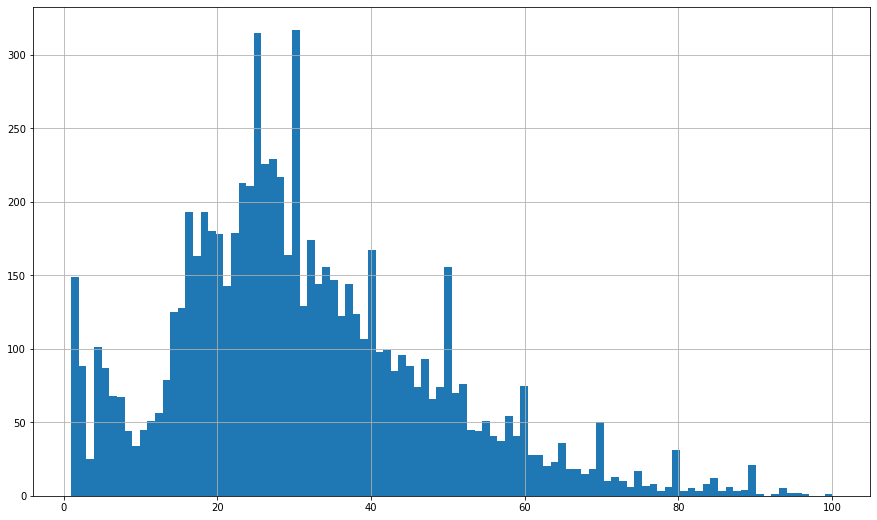

In [6]:
df['real_age'].hist(figsize=(15, 9), bins=100)
plt.ylabel("Количество наблюдений")
plt.xlabel("Возраст");

In [7]:
df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Распределение ожидаемо похоже на нормальное, диапазон возрастов от 1 до 100 лет. Распределение существенно смещено вправо ($\bar{x} = 31.2$), но есть так же выброс в количестве фото от 1 до 8 лет.

Теперь взглянем на изображения.

### Осмотр изображений

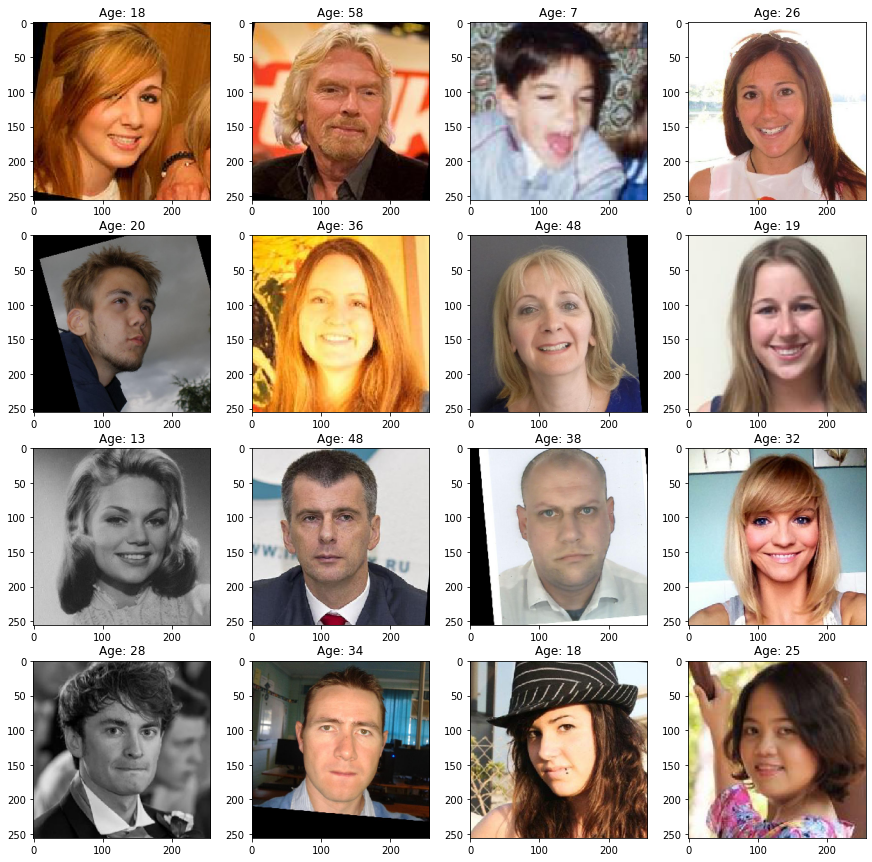

In [8]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))

datagen_contents = next(datagen_flow)

for i in range(16):
    
    pixels = datagen_contents[0][i]
    age = datagen_contents[1][i]
    
    axobject = axs[i // 4][i % 4]
    
    axobject.imshow(pixels)
    axobject.set_title("Age: {0}".format(age))
    axobject.get_yaxis().set_visible(False)
    axobject.get_xaxis().set_visible(False)

Сразу бросается в глаза, что часть изображений уже имеют примененные к ним трансформации: оффсеты и повороты, что поможет в обучении модели.

Лейблы возраста в целом похожи на правду.

Фото выглядят довольно гетерогенными и сняты в различных условиях: от фото на документы до селфи и частей групповых фото, что в некой мере предотвратит переобучение модели.

### Выводы

* В представленном датасете присутствует 7591 размеченных фото людей, что должно быть достаточно для обучения модели.
* Возрасты в данных принимают диапазон от 1 до 100 лет с медианой 29 лет и сдвигом вправо.
* Размеченные возрасты в целом совпадают с фото.
* Часть фото уже имеет примененные к ним трансформации: оффсеты и повороты, что должно улучшить качество обученной модели.
* Фото гетерогенны и сняты при различных условиях, что должно помочь избежать переобучения модели.

## Обучение модели

Обучение модели проводилось на GPU на удаленном сервере, поэтому код здесь оформлен как текстовая ячейка.

```python

import numpy as np
import pandas as pd

from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D as AvgPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):

    datagen = ImageDataGenerator(validation_split=.25, rescale=1/255)

    datagen_flow = datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path + 'labels.csv'),
        directory = path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        batch_size=16,
        seed=111,
        subset='training'
    )
    
    return datagen_flow

def load_test(path):

    datagen = ImageDataGenerator(validation_split=.25, rescale=1/255)

    datagen_flow = datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path + 'labels.csv'),
        directory = path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        batch_size=16,
        seed=111,
        subset='validation'
    )
    
    return datagen_flow

def create_model(input_shape):

    model = Sequential()
    optimizer = Adam(lr=1e-4) 

    backbone = ResNet50(input_shape=input_shape, 
            weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
            include_top=False)

    #backbone.trainable = False

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=30, steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

#create_model((150, 150, 3)).summary()

```

Лог обучения модели.

```

Train for 356 steps, validate for 119 steps

Epoch 1/30

356/356 - 52s - loss: 208.6771 - mae: 10.4250 - val_loss: 525.0569 - val_mae: 17.7342

Epoch 2/30

356/356 - 54s - loss: 71.5123 - mae: 6.3738 - val_loss: 113.9014 - val_mae: 8.0019

Epoch 3/30

356/356 - 65s - loss: 38.3290 - mae: 4.7727 - val_loss: 72.8375 - val_mae: 6.4707

Epoch 4/30

356/356 - 58s - loss: 25.4814 - mae: 3.9007 - val_loss: 81.9742 - val_mae: 6.7874

Epoch 5/30

356/356 - 50s - loss: 16.4543 - mae: 3.1161 - val_loss: 69.1075 - val_mae: 6.2629

Epoch 6/30

356/356 - 64s - loss: 14.7143 - mae: 2.9250 - val_loss: 68.4022 - val_mae: 6.2189

Epoch 7/30

356/356 - 63s - loss: 14.2595 - mae: 2.8532 - val_loss: 78.3453 - val_mae: 6.6137

Epoch 8/30

356/356 - 49s - loss: 12.4158 - mae: 2.6970 - val_loss: 79.2332 - val_mae: 7.0260

Epoch 9/30

356/356 - 64s - loss: 9.4999 - mae: 2.3130 - val_loss: 72.0690 - val_mae: 6.5956

Epoch 10/30

356/356 - 64s - loss: 7.9737 - mae: 2.1310 - val_loss: 65.5712 - val_mae: 6.0504

Epoch 11/30

356/356 - 46s - loss: 7.9809 - mae: 2.1256 - val_loss: 62.0761 - val_mae: 5.9344

Epoch 12/30

356/356 - 65s - loss: 8.6001 - mae: 2.1915 - val_loss: 71.0771 - val_mae: 6.4922

Epoch 13/30

356/356 - 63s - loss: 8.9460 - mae: 2.2634 - val_loss: 64.0302 - val_mae: 6.0585

Epoch 14/30

356/356 - 48s - loss: 8.6301 - mae: 2.2216 - val_loss: 66.0201 - val_mae: 6.0148

Epoch 15/30

356/356 - 65s - loss: 8.7251 - mae: 2.2351 - val_loss: 69.2455 - val_mae: 6.3013

Epoch 16/30

356/356 - 58s - loss: 8.4097 - mae: 2.1631 - val_loss: 63.4963 - val_mae: 5.9395

Epoch 17/30

356/356 - 43s - loss: 7.3435 - mae: 2.0403 - val_loss: 66.7081 - val_mae: 6.3014

Epoch 18/30

356/356 - 41s - loss: 6.4296 - mae: 1.9130 - val_loss: 62.5991 - val_mae: 5.8962

Epoch 19/30

356/356 - 39s - loss: 5.7021 - mae: 1.8050 - val_loss: 63.7386 - val_mae: 6.0218

Epoch 20/30

356/356 - 40s - loss: 5.7042 - mae: 1.8115 - val_loss: 62.6342 - val_mae: 6.0187

Epoch 21/30

356/356 - 40s - loss: 5.7674 - mae: 1.8086 - val_loss: 62.0217 - val_mae: 5.8480

Epoch 22/30

356/356 - 39s - loss: 5.9965 - mae: 1.8365 - val_loss: 60.5300 - val_mae: 5.8559

Epoch 23/30

356/356 - 39s - loss: 5.9574 - mae: 1.8507 - val_loss: 64.3848 - val_mae: 5.7837

Epoch 24/30

356/356 - 39s - loss: 5.9464 - mae: 1.8500 - val_loss: 61.1131 - val_mae: 5.8485

Epoch 25/30

356/356 - 40s - loss: 5.5846 - mae: 1.7857 - val_loss: 62.5159 - val_mae: 5.9261

Epoch 26/30

356/356 - 39s - loss: 4.9355 - mae: 1.6765 - val_loss: 63.5330 - val_mae: 5.9399

Epoch 27/30

356/356 - 41s - loss: 4.4654 - mae: 1.5894 - val_loss: 63.3215 - val_mae: 5.9933

Epoch 28/30

356/356 - 43s - loss: 4.4333 - mae: 1.5742 - val_loss: 64.2025 - val_mae: 5.9138

Epoch 29/30

356/356 - 42s - loss: 7.6073 - mae: 2.0107 - val_loss: 63.0905 - val_mae: 6.0631

Epoch 30/30

356/356 - 43s - loss: 8.3854 - mae: 2.1863 - val_loss: 74.6580 - val_mae: 6.6146



119/119 - 11s - loss: 74.6580 - mae: 6.6146

Test MAE: 6.6146

```

## Анализ обученной модели

* Итоговая модель показала $MAE = 6.61$ на тестовой выборке, что удовлетворяет условию задания ($MAE < 8$).
* Данный результат был получен применением архитектуры ResNet50 с финальным слоем размером 1 и функцией активации ReLU с целью предотвращения отрицательных значений в предсказаниях.
* Основным параметром настройки выступила скорость обучения оптимизатора: при стандартных значениях (1E-3) была замечена немонотонность получаемых между эпохами значений функции потерь, в связи с чем, скорость обучения была понижена до 1E-4. Это позволило получить значения $MAE = 6.61$ на тестовой выборке (для стандартной скорости обучения $MAE_{тест} \approx 8.5 - 9.0$).
* На последних эпохах снова наблюдается немонотонность функции потерь, поэтому, стоит рассмотреь вариант дальнейшего понижения скорости обучения. Вероятно, это позволит достичь $MAE < 6$ на тестовой выборке.